# Multivariate MLP

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
# fix tensorflow gpu problems
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# check gpu support
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus))
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

0
True
True



## 1.Load the dataset

In [4]:
df = pd.read_csv('Lumos5G-v1.0.csv',
                index_col=['run_num', 'seq_num'])
df.head(5)

abstractSignalStr   latitude  longitude  movingSpeed  \
run_num seq_num                                                         
1       1.0                      2  44.975314 -93.259316     0.094889   
        2.0                      2  44.975311 -93.259311     0.876634   
        3.0                      2  44.975305 -93.259292     2.225798   
        4.0                      2  44.975293 -93.259258     3.180726   
        5.0                      2  44.975278 -93.259214     3.751234   

                 compassDirection        nrStatus  lte_rssi  lte_rsrp  \
run_num seq_num                                                         
1       1.0                   150  NOT_RESTRICTED     -61.0       -94   
        2.0                   117  NOT_RESTRICTED     -61.0       -94   
        3.0                   113  NOT_RESTRICTED     -61.0       -94   
        4.0                   114  NOT_RESTRICTED     -59.0       -95   
        5.0                   115  NOT_RESTRICTED     -59.0       -95   

                 lte_rsrq     lte_rssnr  nr_ssRsrp  nr_ssRsrq  nr_ssSinr  \
run_num seq_num                                                            
1       1.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        2.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        3.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        4.0         -16.0  2.147484e+09        NaN        NaN        NaN   
        5.0         -16.0  2.147484e+09        NaN        NaN        NaN   

                 Throughput mobility_mode trajectory_direction  tower_id  
run_num seq_num                                                           
1       1.0              78       driving                   CW        16  
        2.0             117       driving                   CW        16  
        3.0             110       driving                   CW        16  
        4.0             108       driving                   CW        16  
        5.0             100       driving                   CW        16

In [5]:
# select columns
ndf = df[["latitude",
          "longitude",
          "abstractSignalStr",
          "movingSpeed",
          "compassDirection",
          "lte_rssi",
          "lte_rsrp",
          "lte_rsrq",
          "lte_rssnr",
          "nr_ssRsrp",
          "nr_ssRsrq",
          "nr_ssSinr",
          "tower_id",
          "trajectory_direction",
          "mobility_mode",
          "nrStatus",
          "Throughput"]]
ndf.head()

latitude  longitude  abstractSignalStr  movingSpeed  \
run_num seq_num                                                         
1       1.0      44.975314 -93.259316                  2     0.094889   
        2.0      44.975311 -93.259311                  2     0.876634   
        3.0      44.975305 -93.259292                  2     2.225798   
        4.0      44.975293 -93.259258                  2     3.180726   
        5.0      44.975278 -93.259214                  2     3.751234   

                 compassDirection  lte_rssi  lte_rsrp  lte_rsrq     lte_rssnr  \
run_num seq_num                                                                 
1       1.0                   150     -61.0       -94     -14.0  2.147484e+09   
        2.0                   117     -61.0       -94     -14.0  2.147484e+09   
        3.0                   113     -61.0       -94     -14.0  2.147484e+09   
        4.0                   114     -59.0       -95     -16.0  2.147484e+09   
        5.0                   115     -59.0       -95     -16.0  2.147484e+09   

                 nr_ssRsrp  nr_ssRsrq  nr_ssSinr  tower_id  \
run_num seq_num                                              
1       1.0            NaN        NaN        NaN        16   
        2.0            NaN        NaN        NaN        16   
        3.0            NaN        NaN        NaN        16   
        4.0            NaN        NaN        NaN        16   
        5.0            NaN        NaN        NaN        16   

                trajectory_direction mobility_mode        nrStatus  Throughput  
run_num seq_num                                                                 
1       1.0                       CW       driving  NOT_RESTRICTED          78  
        2.0                       CW       driving  NOT_RESTRICTED         117  
        3.0                       CW       driving  NOT_RESTRICTED         110  
        4.0                       CW       driving  NOT_RESTRICTED         108  
        5.0                       CW       driving  NOT_RESTRICTED         100

In [6]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 68118 entries, (1, 1.0) to (118, 783.0)
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   latitude              68118 non-null  float64
 1   longitude             68118 non-null  float64
 2   abstractSignalStr     68118 non-null  int64  
 3   movingSpeed           68118 non-null  float64
 4   compassDirection      68118 non-null  int64  
 5   lte_rssi              65137 non-null  float64
 6   lte_rsrp              68118 non-null  int64  
 7   lte_rsrq              65137 non-null  float64
 8   lte_rssnr             65137 non-null  float64
 9   nr_ssRsrp             51990 non-null  float64
 10  nr_ssRsrq             51990 non-null  float64
 11  nr_ssSinr             51990 non-null  float64
 12  tower_id              68118 non-null  int64  
 13  trajectory_direction  68118 non-null  object 
 14  mobility_mode         68118 non-null  object 
 15  nrSta

In [7]:
#ndf = ndf.fillna(method='backfill')
ndf = ndf.fillna(0) # fill with zeros
ndf.isna().sum().sum() # check nans

0

In [8]:
max_throughput = ndf["Throughput"].max()
min_throughput = ndf["Throughput"].min()
print(f'Max throughput: {max_throughput}')
print(f'Min throughput: {min_throughput}')

Max throughput: 1920
Min throughput: 0


In [9]:
# label encoding
directions = list(ndf['trajectory_direction'].unique())
print('Directions', directions)
enc = preprocessing.LabelEncoder()
ndf['trajectory_direction'] = enc.fit_transform(ndf['trajectory_direction'].values.ravel())
mobility_mode = list(ndf['mobility_mode'].unique())
print('Mobility mode', mobility_mode)
enc = preprocessing.LabelEncoder()
ndf['mobility_mode'] = enc.fit_transform(ndf['mobility_mode'].values.ravel())
nrStatus = list(ndf['nrStatus'].unique())
print('nrStatus', nrStatus)
enc = preprocessing.LabelEncoder()
ndf['nrStatus'] = enc.fit_transform(ndf['nrStatus'].values.ravel())
ndf.head()

Directions ['CW', 'ACW']
Mobility mode ['driving', 'walking']
nrStatus ['NOT_RESTRICTED', 'CONNECTED', 'NONE']


latitude  longitude  abstractSignalStr  movingSpeed  \
run_num seq_num                                                         
1       1.0      44.975314 -93.259316                  2     0.094889   
        2.0      44.975311 -93.259311                  2     0.876634   
        3.0      44.975305 -93.259292                  2     2.225798   
        4.0      44.975293 -93.259258                  2     3.180726   
        5.0      44.975278 -93.259214                  2     3.751234   

                 compassDirection  lte_rssi  lte_rsrp  lte_rsrq     lte_rssnr  \
run_num seq_num                                                                 
1       1.0                   150     -61.0       -94     -14.0  2.147484e+09   
        2.0                   117     -61.0       -94     -14.0  2.147484e+09   
        3.0                   113     -61.0       -94     -14.0  2.147484e+09   
        4.0                   114     -59.0       -95     -16.0  2.147484e+09   
        5.0                   115     -59.0       -95     -16.0  2.147484e+09   

                 nr_ssRsrp  nr_ssRsrq  nr_ssSinr  tower_id  \
run_num seq_num                                              
1       1.0            0.0        0.0        0.0        16   
        2.0            0.0        0.0        0.0        16   
        3.0            0.0        0.0        0.0        16   
        4.0            0.0        0.0        0.0        16   
        5.0            0.0        0.0        0.0        16   

                 trajectory_direction  mobility_mode  nrStatus  Throughput  
run_num seq_num                                                             
1       1.0                         1              0         2          78  
        2.0                         1              0         2         117  
        3.0                         1              0         2         110  
        4.0                         1              0         2         108  
        5.0                         1              0         2         100

In [10]:
# Min-Max Scaling
df=(ndf-ndf.min())/(ndf.max()-ndf.min())
df.head()

latitude  longitude  abstractSignalStr  movingSpeed  \
run_num seq_num                                                        
1       1.0      0.555052   0.931652               0.25     0.006749   
        2.0      0.554351   0.932764               0.25     0.062350   
        3.0      0.552584   0.936669               0.25     0.158308   
        4.0      0.549415   0.943976               0.25     0.226227   
        5.0      0.545235   0.953213               0.25     0.266804   

                 compassDirection  lte_rssi  lte_rsrp  lte_rsrq  lte_rssnr  \
run_num seq_num                                                              
1       1.0              0.416667  0.227848  0.479167       0.3        1.0   
        2.0              0.325000  0.227848  0.479167       0.3        1.0   
        3.0              0.313889  0.227848  0.479167       0.3        1.0   
        4.0              0.316667  0.253165  0.468750       0.2        1.0   
        5.0              0.319444  0.253165  0.468750       0.2        1.0   

                 nr_ssRsrp     nr_ssRsrq  nr_ssSinr  tower_id  \
run_num seq_num                                                 
1       1.0            1.0  9.313226e-09        0.4  0.652174   
        2.0            1.0  9.313226e-09        0.4  0.652174   
        3.0            1.0  9.313226e-09        0.4  0.652174   
        4.0            1.0  9.313226e-09        0.4  0.652174   
        5.0            1.0  9.313226e-09        0.4  0.652174   

                 trajectory_direction  mobility_mode  nrStatus  Throughput  
run_num seq_num                                                             
1       1.0                       1.0            0.0       1.0    0.040625  
        2.0                       1.0            0.0       1.0    0.060937  
        3.0                       1.0            0.0       1.0    0.057292  
        4.0                       1.0            0.0       1.0    0.056250  
        5.0                       1.0            0.0       1.0    0.052083

## 2. Create Train-Test Sets

In [11]:
# split function into sequences
# y data from the last column 
def multistep_split(seq, n_steps_in, n_steps_out):
    X = list()
    y = list()
    for i in range(len(seq)):
        # pattern end
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(seq):
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
# separately splits runs into sequences
run_max=df.index.max()[0]
seconds_in = 20
seconds_out = 20 
X_list = list()
y_list = list()
for run_num in range(1, run_max+1):
    run = df.loc[run_num].values
    X, y = multistep_split(run.astype('float32'), n_steps_in=seconds_in, n_steps_out=seconds_out)
    X_list.append(X)
    y_list.append(y)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print(X.shape)
print(y.shape)

(63516, 20, 17)
(63516, 20)


In [13]:
ratio=0.7 
train_size = int(ratio*X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(44461, 20, 17)
(44461, 20)
(19055, 20, 17)
(19055, 20)


In [14]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train_fl = X_train.reshape((X_train.shape[0], n_input))
X_test_fl = X_test.reshape((X_test.shape[0], n_input))
print(X_train_fl.shape)
print(X_test_fl.shape)

(44461, 340)
(19055, 340)


## 3.Define MLP

In [15]:
def mlp(n_input, seconds_out, lr=0.0001):
    # define layers
    inputs = tf.keras.Input(shape=(n_input,))
    reg = tf.keras.regularizers.l2(0.00001)
    dense1 = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=reg)
    dense2 = tf.keras.layers.Dense(512, activation='relu',  kernel_regularizer=reg)
    dense3 = tf.keras.layers.Dense(128, activation='relu',  kernel_regularizer=reg)
    outputs = tf.keras.layers.Dense(seconds_out, activation='linear')
    layers = [inputs, dense1, dense2, dense3, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

## 4. Train MLP

In [16]:
model = mlp(n_input, seconds_out, lr=0.0001)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              349184    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2580      
Total params: 942,228
Trainable params: 942,228
Non-trainable params: 0
_________________________________________________________________


In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0001,
                                                  patience=20,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)
history = model.fit(X_train_fl,
                    y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_test_fl, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
1390/1390 [==============================] - 12s 8ms/step - loss: 0.1491 - val_loss: 0.0891
Epoch 2/50
1390/1390 [==============================] - 11s 8ms/step - loss: 0.0835 - val_loss: 0.0685
Epoch 3/50
1390/1390 [==============================] - 11s 8ms/step - loss: 0.0656 - val_loss: 0.0586
Epoch 4/50
1390/1390 [==============================] - 11s 8ms/step - loss: 0.0553 - val_loss: 0.0517
Epoch 5/50
1390/1390 [==============================] - 11s 8ms/step - loss: 0.0488 - val_loss: 0.0464
Epoch 6/50
1390/1390 [==============================] - 11s 8ms/step - loss: 0.0440 - val_loss: 0.0443
Epoch 7/50
1390/1390 [==============================] - 11s 8ms/step - loss: 0.0413 - val_loss: 0.0454
Epoch 8/50
1390/1390 [==============================] - 12s 9ms/step - loss: 0.0391 - val_loss: 0.0401
Epoch 9/50
1390/1390 [==============================] - 12s 8ms/step - loss: 0.0365 - val_loss: 0.0401
Epoch 10/50
1390/1390 [==============================] - 11s 8ms/step - l

Minimal Loss: 0.0348
RMSE: 357.9 Mbps


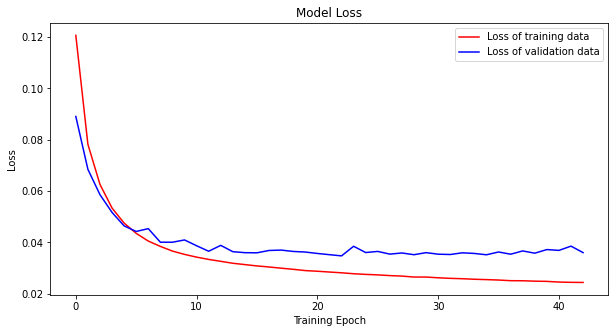

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_mse = min(val_loss)
print(f'Minimal Loss: {min_mse:.4f}')
print(f'RMSE: {np.sqrt(min_mse)*max_throughput:.1f} Mbps')
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Loss of training data')
plt.plot(val_loss, 'b-', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

## 5. Test-Prediction Comparision

Forecast MSE of the example: 0.0136


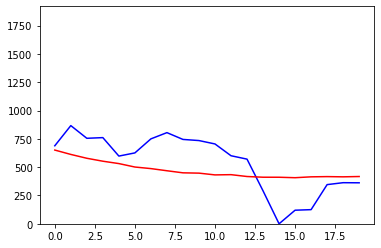

In [22]:
n = 300 # test example number
x_in = X_test_fl[n].reshape(1,-1)
y_true = y_test[n] # test true
y_pred = model.predict(x_in).flatten()
plt.plot(y_true*max_throughput, 'b')
plt.plot(y_pred*max_throughput, 'r')
plt.ylim(0, max_throughput)
print(f'Forecast MSE of the example: {mean_squared_error(y_true, y_pred):.4f}')
plt.show()